In [4]:
import pandas as pd
df_combined=pd.read_csv('/content/drive/MyDrive/df_combined_l-5.csv')

In [3]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 32.7 MB/s eta 0:00:00


In [5]:
import torch
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Okt 토크나이저 사용
okt = Okt()
# 불용어 리스트 (필요에 따라 수정)
stop_words = ['한', '에서', '하다', '를', '한다는', '이라는', '까지', '에서는', '으로', '인데', '이고', '에요', '이를', '있다', '여서', '이다',
              '부터', '지인', '짜다', '라고', '되었다', '고함', '고해']

def clean_text(text):
    # 텍스트가 문자열일 경우에만 처리
    if isinstance(text, str):
        # 특수 문자 제거
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
        return text
    return ''  # 텍스트가 문자열이 아니면 빈 문자열 반환

def tokenize_text(text):
    # 형태소 분석을 통한 토큰화
    return okt.morphs(text)

def sentence_length(text):
    return len(text.split())

def vocab_diversity(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0

def preprocess(df):
    df['cleaned_text'] = df['sentence'].apply(clean_text)  # 문장 정제
    df['tokens'] = df['cleaned_text'].apply(tokenize_text)  # 형태소 분석 후 토큰화
    # 품사 태깅 (명사, 동사, 형용사만 추출)
    df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words and len(word) > 1])
    # 특성 추가: 문장 길이, 어휘 다양성
    df['sentence_length'] = df['sentence'].apply(sentence_length)
    df['vocab_diversity'] = df['sentence'].apply(vocab_diversity)

    return df



# NaN 값이나 비어 있는 텍스트를 미리 처리
df_combined['sentence'] = df_combined['sentence'].fillna('')  # NaN을 빈 문자열로 대체

# 전처리
df_combined = preprocess(df_combined)

# 모델용 데이터셋 준비
train_df, test_df = train_test_split(df_combined[['sentence', 'label']], test_size=0.2, random_state=42)

# Hugging Face의 DistilBERT 토크나이저 불러오기
tokenizer = DistilBertTokenizerFast.from_pretrained("monologg/distilkobert")

# 토크나이저를 사용하여 텍스트를 인덱스로 변환
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=512)

train_data = Dataset.from_pandas(train_df[['sentence', 'label']])
test_data = Dataset.from_pandas(test_df[['sentence', 'label']])

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# 모델 불러오기
model = DistilBertForSequenceClassification.from_pretrained("monologg/distilkobert", num_labels=2)

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="none",
    load_best_model_at_end=True,  # 가장 좋은 모델 로드
    metric_for_best_model='eval_accuracy',  # 성능 지표로 사용할 것
    greater_is_better=True,  # 정확도가 높은 것이 더 좋음
    logging_steps=50,
    adam_epsilon=1e-8,
    warmup_steps=500,
)
# compute_metrics 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)



# 모델 학습
trainer.train()

# 훈련이 끝난 후 가장 좋은 성능을 얻은 모델을 찾기
best_accuracy = 0
best_epoch = -1

# 각 epoch의 평가 정확도를 추적하고, 가장 좋은 정확도를 기록
for epoch in range(training_args.num_train_epochs):
    eval_result = trainer.evaluate(eval_dataset=test_data)
    eval_accuracy = eval_result['eval_accuracy']

    # 가장 높은 정확도를 기록하고 모델 저장
    if eval_accuracy > best_accuracy:
        best_accuracy = eval_accuracy
        best_epoch = epoch
        trainer.save_model(f'./best_model_epoch_{epoch}')  # 각 epoch마다 가장 좋은 모델 저장

# 훈련 후 최종 평가
trainer.evaluate()

# 예측 및 평가
predictions = trainer.predict(test_data)
predicted_labels = predictions.predictions.argmax(-1)  # 가장 높은 확률을 가진 클래스 선택
true_labels = test_data['label']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


Map:   0%|          | 0/4049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1013 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at monologg/distilkobert and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.681200,0.650667,0.565647
2,0.521400,0.445535,0.843040
3,0.415900,0.395868,0.839092
4,0.385900,0.345451,0.855874
5,0.333200,0.329173,0.863771
6,0.331700,0.344219,0.866732
7,0.291300,0.382624,0.822310
8,0.295700,0.321492,0.867720
9,0.274300,0.324125,0.870681
10,0.276200,0.330881,0.870681


Accuracy: 87.07%
              precision    recall  f1-score   support

       Human       0.87      0.90      0.88       561
         GPT       0.87      0.84      0.85       452

    accuracy                           0.87      1013
   macro avg       0.87      0.87      0.87      1013
weighted avg       0.87      0.87      0.87      1013



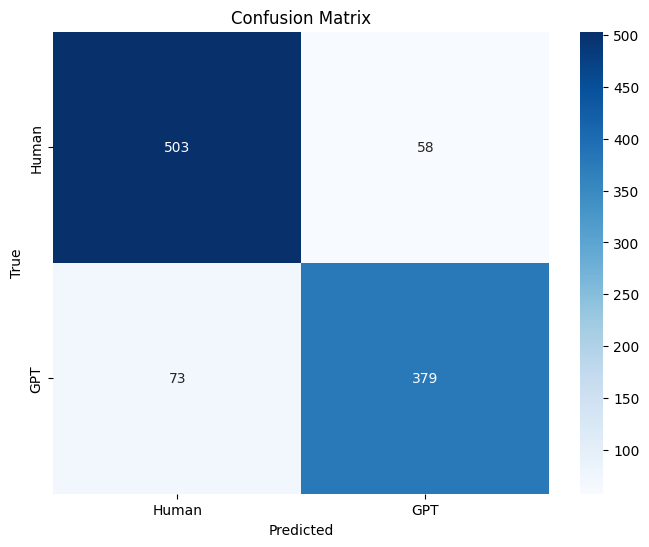

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 테스트 데이터에 대한 예측 생성
predictions = trainer.predict(test_data)
predicted_labels = predictions.predictions.argmax(-1)  # 가장 높은 확률을 가진 클래스 선택

# 실제 레이블
true_labels = test_data['label']  # 수정된 부분

# 정확도 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# 성능 보고서 생성
report = classification_report(true_labels, predicted_labels, target_names=['Human', 'GPT'])  # 클래스 이름을 '인간', 'GPT'로 수정
print(report)

# 혼돈 행렬 계산 및 시각화
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'GPT'], yticklabels=['Human', 'GPT'])  # 클래스 이름을 '인간', 'GPT'로 수정
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



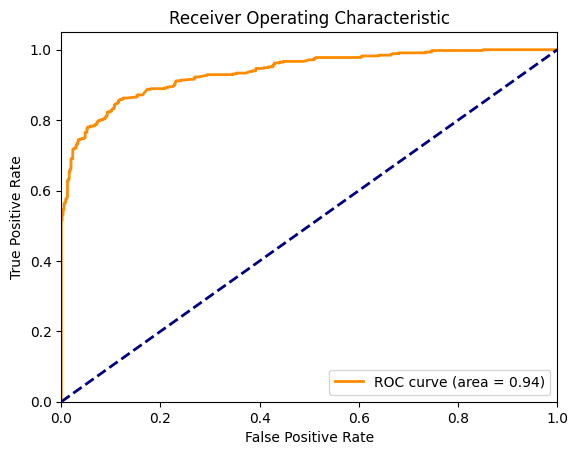

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예측 확률 얻기 (predictions.predictions는 모든 클래스에 대한 확률을 포함)
probabilities = predictions.predictions
# positive 클래스에 대한 확률 추출 (두 번째 열)
positive_probabilities = probabilities[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(true_labels, positive_probabilities)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 모델 저장
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install transformers